In [164]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2
from myshow import myshow
from scipy import linalg
from scipy.io import loadmat, savemat
import sys

sys.path.append('include')
import cardiacDicomGlobals as cdg
import reconPipelineFunctions as recon
import validationPipelineFunctions as validate

%matplotlib inline


def closestIndex(f, faxis):
    return np.argmin(np.abs(faxis-f))

In [165]:
patientIndex = 6
currentPatient = cdg.patientList[patientIndex]

doGlobalFreqSearch = False
multiCoilProcessing = False # index of the one we have to do SOS on
channelList = [5,6,7]
#0 good bicarb
#2: good pyruvate ex
#3: good pyruvate ex !!
#7 good bicarb

Generate the frequency axis. Make sure this is identical to that used in the matlab script. Currently we're going from -45 to 45 in steps of 5

In [166]:
fmin = -45
fmax = 45
df = 5
nf = int((fmax - fmin)/df + 1)
freqAxis = np.linspace(fmin, fmax, nf)

gfmin = -15
gfmax = 15
ngf = int((gfmax - gfmin)/df + 1)
globalFreqSearch = np.linspace(gfmin, gfmax, ngf) 

globalOnResInd = cdg.closestIndex(0, globalFreqSearch)
onResInd = closestIndex(0, freqAxis)


Determine the MFI coefficcients. This uses the frequency axis plus the time axis stores in the waveform mat file. From the article "Multifrequency Interpolation for Fast Off-resonance Correction," images are reconstructed by 
\begin{equation*}
I_{cp}\approx \sum_{i=1}^{L}\, c_i(\Delta\omega(\vec{r}))I_i(\vec{r})
\end{equation*}
where the $I_i(\vec{r}$ isthe image reconstructed at frequency $i$, and $c_i(\Delta\omega(\vec{r}))$ are the MFI coefficients. The coefficients are solutions to 
\begin{equation*}
e^{-j \Delta\omega t_k}
\approx \sum_{i=1}^{L}\, c_i(\Delta\omega(\vec{r}))e^{-j \Delta\omega_i t_k}
\end{equation*}
This equation is solved for via least squares

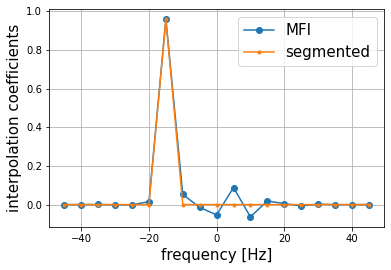

In [167]:

cjmat = recon.generateMFICoefficients(freqAxis, currentPatient)
        
sampleF = 6
segmentedCoeffs = np.zeros(nf)
segmentedCoeffs[sampleF] = np.real(cjmat[sampleF,:]).max()

fs = 15
fig, axes = plt.subplots()

axes.plot(freqAxis, np.real(cjmat[sampleF,:]),'o-', label='MFI')
axes.plot(freqAxis, segmentedCoeffs, '.-', label='segmented')
axes.set_xlabel('frequency [Hz]', fontsize=fs)
axes.set_ylabel('interpolation coefficients', fontsize=fs)
axes.legend(fontsize=fs)
axes.grid(True)

fig.savefig('rawFigs/MFI_coeffs.pdf')


Load all the data. 
* From Dicom: B0 maps
* from png image: mask
* from mat files: c13 MFR reconstructions

In [168]:

b0mag = sitk.ReadImage(currentPatient.b0mag)
b0phase = sitk.ReadImage(currentPatient.b0phase)
loc = sitk.ReadImage(currentPatient.loc)
c13 = sitk.ReadImage(currentPatient.c13)

Since the mask is regular png image, we need to give it coordinates. It has identical resolution and header as the localizer, so we copy it from there. SITK needs a 3D array for single slice 2D images, so add that here

In [169]:
maskSITK = recon.getHeartMask(currentPatient, loc)
myshow(maskSITK)

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…



process B0 map. For now just apply median filter

(-0.5, 63.5, 63.5, -0.5)

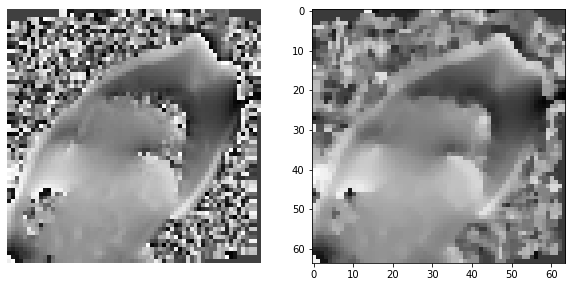

In [170]:
b0phasef, b0phasePixels, medianFiltered = recon.filterB0Map(b0phase)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(b0phasePixels, cmap='gray')
ax2.imshow(medianFiltered, cmap='gray')
ax1.axis('off')


In [171]:
myshow(loc)

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…

resample to c13 target image

In [172]:
b0phase_r = recon.resampleSITKImage(c13,b0phasef) # passed through median filter
b0phaseOrig_r = recon.resampleSITKImage(c13,b0phase) # not filtered
b0mag_r = recon.resampleSITKImage(c13,b0mag)
mask_r = recon.resampleSITKImage(c13,maskSITK)
loc_r = recon.resampleSITKImage(c13,loc)

maskPixels = np.squeeze(sitk.GetArrayFromImage(mask_r))


Progress: 100.0%...

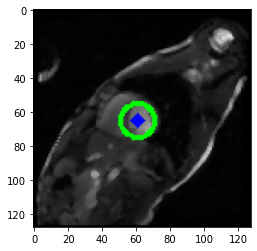

In [173]:
# optional try to detect myocardium using hough transform 

locPixels = np.squeeze(sitk.GetArrayFromImage(loc_r))
locPixels = validate.floatToInt2(locPixels)
locPixels = cv2.medianBlur(locPixels,3)
grd = validate.imageGrad(locPixels,1)
#plt.imshow(locPixels)
cimg = cv2.cvtColor(locPixels,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(locPixels,cv2.HOUGH_GRADIENT, 1.2, 100,
                            param1=50,param2=30, minRadius=3, maxRadius=15)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
#cv2.imshow('detected circles',cimg)
plt.imshow(cimg)



We need a threshold for applying the MFR. Either the loc or b0mag should work

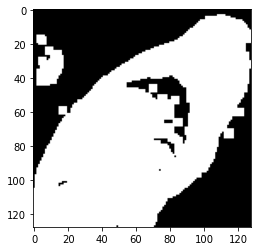

In [174]:
locMask = recon.getThresholdFromLoc(loc_r)
plt.imshow(locMask)


Load multi-freq matlab files. One set needs to be multi-channel process, so we add the magnitude channels here. |

In [175]:
mfr, mfrc = recon.loadMultiFrequencyFiles(currentPatient, freqAxis, multiCoilProcessing)

image array shape
(128, 128, 8, 3, 19)


This cell applies the MFI and frequency segmented recon based on the B0 map. One additional uncertainty is the global frequency shift accounting for errors in $\omega_C = \alpha \omega_H$. Therefore, the entire MFI is performed at a small search space in this list called "globalFreqSearch."   




In [176]:
mf, mfi, globalFreqSearch = recon.runMFI(globalFreqSearch, freqAxis, b0phase_r, locMask, mfr, mfrc, cjmat, multiCoilProcessing)


Here we pick the best global shift from the data. We use the peak signal from the bicarbonate to accopmplish this. In most cases, the first 2 bicarb images have no actual signal, but may contain a subtstantial artifact from pyruvate. Therefore these are filtered off. We look at several objective functions for choosing this frequency
* mean of an upper quantile, only within mask pixels
\begin{equation*}
\phi= \textrm{mean}(Q4(I(\mathbf{r})))\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

* mean of the absolute image gradient, only within mask pixels

\begin{equation*}
\phi= \textrm{mean}\left(\left|\nabla I(\mathbf{r})\right|\right)\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

* mean of the upper quantile of the absolute image gradient, only within mask pixels

\begin{equation*}
\phi= \textrm{mean}\left( Q4\left(\left|\nabla I(\mathbf{r})\right|\right)\right)\textrm{ s.t. } \mathbf{r}\in\textrm{mask} 
\end{equation*}

In [177]:
print(mf.shape)
print(mfi.shape[2])
print(mfr.shape)


(128, 128, 8, 3, 7)
8
(128, 128, 8, 3, 19)


In [178]:

kernelSize = 3



    
maskPixels = np.squeeze(sitk.GetArrayFromImage(mask_r))
peakTime = validate.findPeakSignalImages(mfi, maskPixels, globalOnResInd)                          
print('peak signal time indices: '+str(peakTime))

peak signal time indices: [2. 1. 1.]


In [179]:

peakSignalUncorr, peakSignalMFI, peakSignalSeg = validate.applyObjectiveMetric(freqAxis,globalFreqSearch, mfr, mfi, mf, peakTime, maskPixels)

im = 2  # which met to optimize on  
bestGlobalShiftUncorr = np.argmax(peakSignalUncorr[im,:])    
bestGlobalShift       = np.argmax(peakSignalSeg[im,:])

print('best global shift is at '+str(globalFreqSearch[bestGlobalShift])+' Hz')
print('best global shift-only is at '+str(globalFreqSearch[bestGlobalShiftUncorr])+' Hz')


# no correction
img_unc = np.abs(np.squeeze(mfr[:, :, :, :, onResInd]))
#global shift only 
img_gs = np.abs(np.squeeze(mfr[:, :, :, :, cdg.closestIndex(globalFreqSearch[bestGlobalShift], freqAxis)]))
#global shift + freq segmented
img_seg_complex = np.squeeze(mf[:,:,:,:,bestGlobalShift])
img_seg = np.abs(img_seg_complex)
#global shift + MFI
img_mfi = np.abs(np.squeeze(mfi[:,:,:,:,bestGlobalShift]))


best global shift is at 0.0 Hz
best global shift-only is at 5.0 Hz


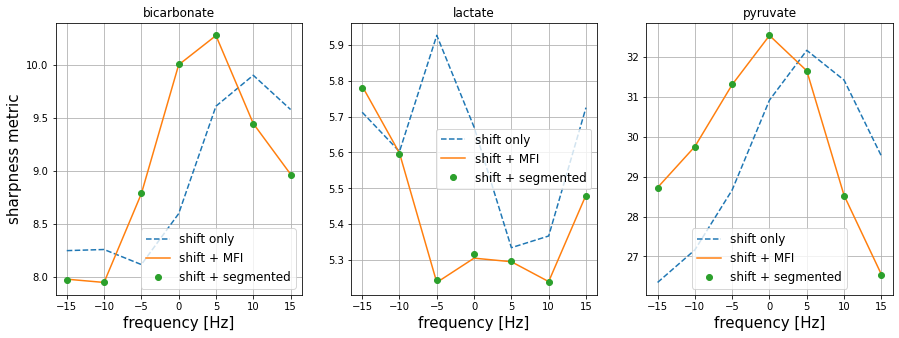

In [180]:
fs = 15


    
    
fig2, axes2 = plt.subplots(1, 3, figsize=(15,5))
titles = ['bicarbonate','lactate','pyruvate']
for x in range(0, 3): 
    axes2[x].plot(globalFreqSearch, peakSignalUncorr[x,:], '--',label='shift only')
    axes2[x].plot(globalFreqSearch, peakSignalMFI[x,:], '-', label='shift + MFI')
    axes2[x].plot(globalFreqSearch, peakSignalSeg[x,:], 'o',label='shift + segmented')
    axes2[x].legend(fontsize=12)
    axes2[x].grid(True)
    axes2[x].set_xlabel('frequency [Hz]', fontsize=fs)
    axes2[x].set_title(titles[x])
axes2[0].set_ylabel('sharpness metric', fontsize=fs)





fig2.savefig('rawFigs/sharpnessMeasure.pdf')


compare corrected to uncorrected

Text(0.5, 1.0, 'MFI')

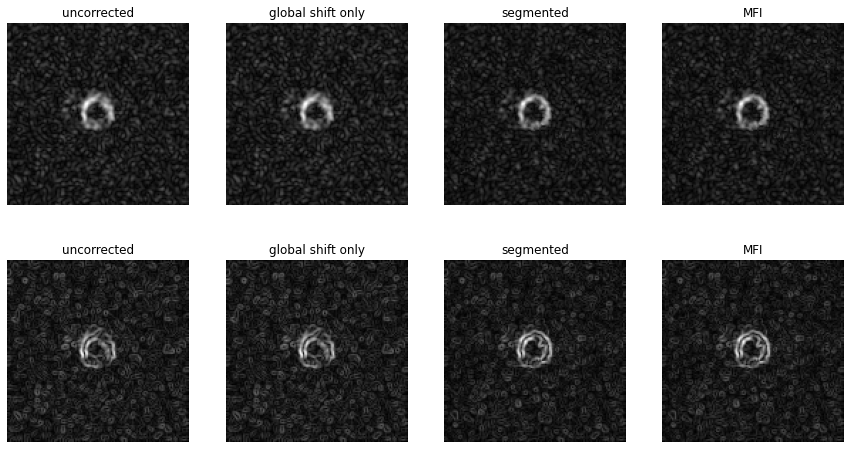

In [181]:
im = 0
it = 2



fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4,figsize=(15,8))
ax1.imshow(img_unc[:,:,it,im] , cmap='gray')
ax1.axis('off')
ax1.set_title('uncorrected')

ax2.imshow(img_gs[:,:,it,im], cmap='gray')
ax2.axis('off')
ax2.set_title('global shift only')

ax3.imshow(img_seg[:,:,it,im], cmap='gray')
ax3.axis('off')
ax3.set_title('segmented')

ax4.imshow(img_mfi[:,:,it,im], cmap='gray')
ax4.axis('off')
ax4.set_title('MFI')



ax5.imshow(validate.imageGrad(img_unc[:,:,it,im], kernelSize) , cmap='gray')
ax5.axis('off')
ax5.set_title('uncorrected')

ax6.imshow(validate.imageGrad(img_gs[:,:,it,im], kernelSize), cmap='gray')
ax6.axis('off')
ax6.set_title('global shift only')

ax7.imshow(validate.imageGrad(img_seg[:,:,it,im], kernelSize), cmap='gray')
ax7.axis('off')
ax7.set_title('segmented')

ax8.imshow(validate.imageGrad(img_mfi[:,:,it,im], kernelSize), cmap='gray')
ax8.axis('off')
ax8.set_title('MFI')




In [182]:
peakTime[0]

2.0

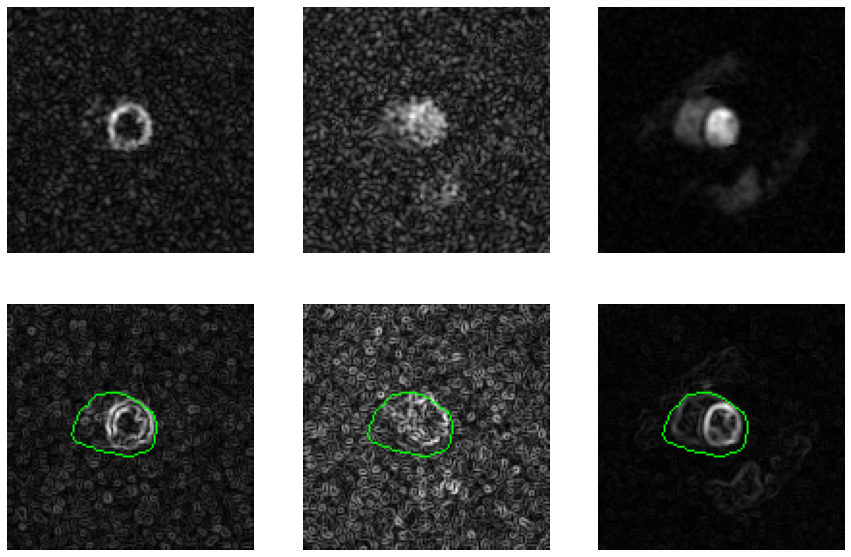

In [183]:


maskGrd  = validate.floatToInt2(maskPixels)
ret,thresh = cv2.threshold(maskGrd, 127, 255, 0)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contourlw = 1


fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(15,10))



img = img_mfi[:,:,int(peakTime[0]),0]
img = validate.floatToInt2(img)
grd = validate.floatToInt2(validate.imageGrad(img, 3))
grd = cv2.cvtColor(grd, cv2.COLOR_GRAY2RGB)
grd = cv2.drawContours(grd, contours, -1, (0,255,0), contourlw)
ax1.imshow(img, cmap='gray')
ax1.axis('off')
ax4.imshow(grd)
ax4.axis('off')

img = img_mfi[:,:,int(peakTime[1]),1]
img = validate.floatToInt2(img)
grd = validate.floatToInt2(validate.imageGrad(img, 3))
grd = cv2.cvtColor(grd, cv2.COLOR_GRAY2RGB)
grd = cv2.drawContours(grd, contours, -1, (0,255,0), contourlw)
ax2.imshow(img, cmap='gray')
ax2.axis('off')
ax5.imshow(grd)
ax5.axis('off')

img = img_mfi[:,:,int(peakTime[2]),2]
img = validate.floatToInt2(img)
grd = validate.floatToInt2(validate.imageGrad(img, 3))
grd = cv2.cvtColor(grd, cv2.COLOR_GRAY2RGB)
grd = cv2.drawContours(grd, contours, -1, (0,255,0), contourlw)
ax3.imshow(img, cmap='gray')
ax3.axis('off')
ax6.imshow(grd)
ax6.axis('off')

fig.savefig('rawFigs/imgGrad.pdf')



In [184]:


dicomKey = 'ImagingFrequency'
keys = loc.GetMetaDataKeys()
h1freq = float(b0mag.GetMetaData('0018|0084'))
c13FreqAdjustment = globalFreqSearch[bestGlobalShift] * 1e-6
c13freq = float(c13.GetMetaData('0018|0084'))

print('1H freq (dicom header) = '+ str(h1freq))
print('13C freq (dicom header) = '+ str(c13freq))
print('13C freq adjustment (from reconstruction) = '+ str(c13FreqAdjustment))

ratio = (c13freq+c13FreqAdjustment)/h1freq
print('ratio = '+str(ratio))




1H freq (dicom header) = 127.736283
13C freq (dicom header) = 32.124311
13C freq adjustment (from reconstruction) = 0.0
ratio = 0.25148932038362193


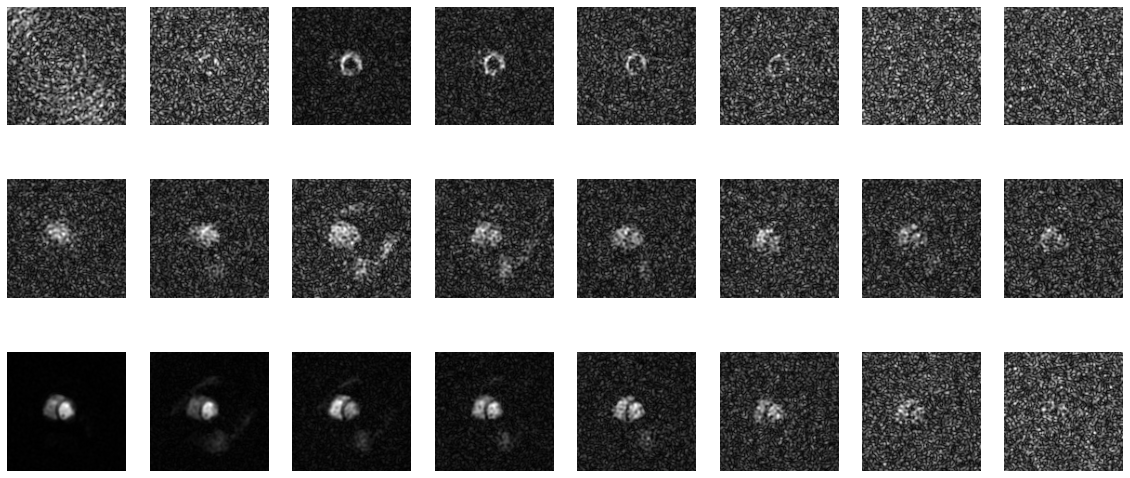

In [185]:
cdg.plotC13Mat(img_unc)

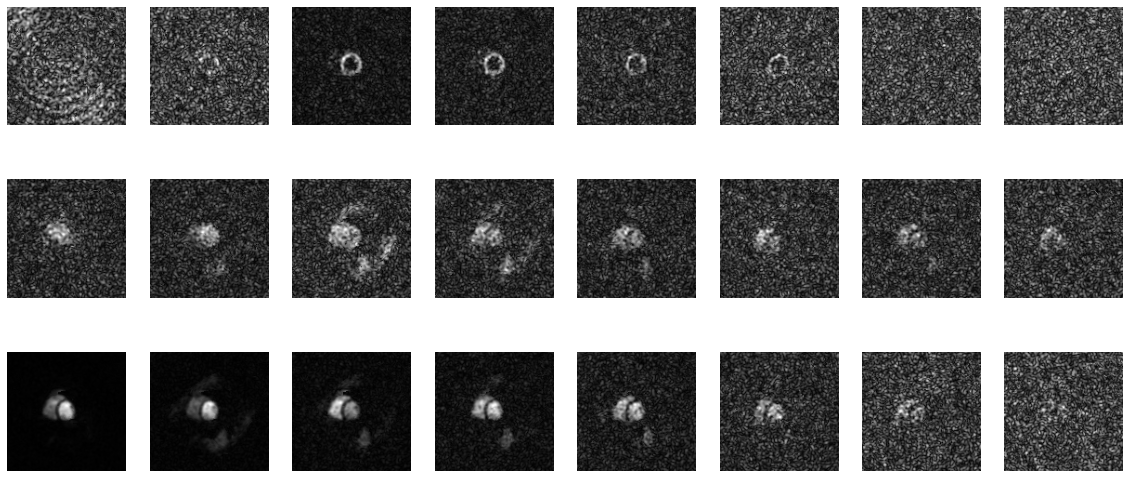

In [186]:
cdg.plotC13Mat(img_mfi)

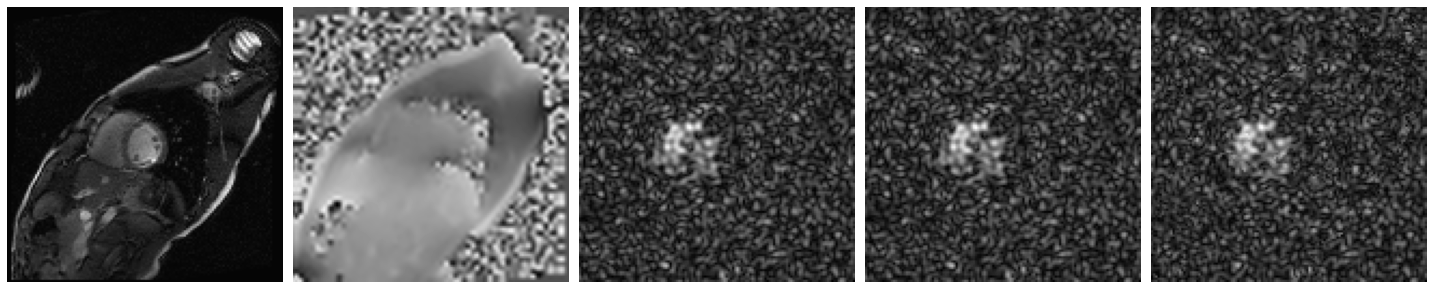

In [187]:
im = 1
it = 5

b0map = np.squeeze(sitk.GetArrayFromImage(b0phaseOrig_r))

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(20,5))

ax1.imshow(np.squeeze(sitk.GetArrayFromImage(loc_r)), cmap='gray')
ax1.axis('off')
ax2.imshow(b0map, cmap='gray')
ax2.axis('off')
ax3.imshow(img_unc[:,:,it,im], cmap='gray')
ax3.axis('off')
ax4.imshow(img_gs[:,:,it,im], cmap='gray')
ax4.axis('off')
ax5.imshow(img_mfi[:,:,it,im], cmap='gray')
ax5.axis('off')
fig.tight_layout()


fig.savefig('rawFigs/exampleImprovement.png')


Save corrected images at mat file

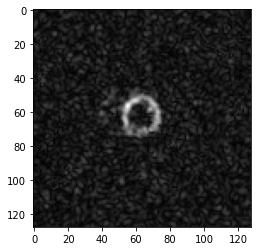

In [188]:





plt.imshow(np.abs(img_seg_complex [:,:,2,0]))



In [189]:
fileDict = dict()
fileDict["img"] = img_seg_complex
outFileName = "forZinzeng/"+currentPatient.mfr+".mat"
savemat(outFileName, fileDict)



